# **Lista 4** de Aprendizagem Automática

## **Assuntos:** Redes Neurais Artificiais

*   **Aluna:** Bárbara Neves
*   **Matrícula:** 507526

---

> <font color='blue'>**Jupyter notebook desenvolvido no Google Colab.**</font> Também pode ser acessado através do [link](https://github.com/barbaraneves/masters-machine-learning-course) no GitHub, sem alterações após o envio pelo SIGAA.



# Imports Principais

Neste notebook, utilizo apenas as bibliotecas presentes na célula abaixo, juntamente com alguns módulos da biblioteca **Scikit-learn**, **tqdm**, **math**, **random**, e **time**.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Implementações

## Utils

<font color='red'>**Sobre o código:**</font> a seguir estão as funções auxiliares, utilitárias ou de suporte que são usadas para auxiliar na resolução das questões desta lista de exercícios. As três primeiras funções presentes na primeira célula desta seção foram criadas para a Lista 2 e reaproveitadas aqui.

In [ ]:
from sklearn.preprocessing import StandardScaler

# FUNÇÕES DA LISTA 2
def plot_class_counts(data, width=6, height=5, palette='coolwarm'):
  plt.figure(figsize=(width, height))

  sns.countplot(data=data, palette=palette)
  plt.xlabel('Classes')
  plt.ylabel('Count')
  plt.show()

def normalize_data(X):
  scaler = StandardScaler()
  X_norm = scaler.fit_transform(X)
  X_norm = pd.DataFrame(X_norm, columns=X.columns)

  fig, axs = plt.subplots(1, 2, figsize=(12, 6))
  sns.lineplot(data=X, ax=axs[0], legend=False, palette='coolwarm_r')
  axs[0].set_title('Antes da Normalização')
  sns.lineplot(data=X_norm, ax=axs[1], legend=False, palette='coolwarm')
  axs[1].set_title('Depois da Normalização')
  plt.show()

  return scaler, X_norm.values

def plot_gaussian_distribution(data):
  sns.kdeplot(data, legend=False, palette='coolwarm', fill=True, common_norm=False)

  plt.title("Distribuição de X")
  plt.xlabel('Valores')
  plt.ylabel('Densidade')
  plt.show()

## Random Search

> *Utilize o conjunto de validação para ajustar os hiperparâmetros.*

<font color='red'>**Sobre o código:**</font> o código apresentado possui a  função **`random_search`**, que implementa uma busca aleatória em um espaço de hiperparâmetros para encontrar o melhor conjunto de parâmetros para um determinado modelo. Abaixo está uma descrição do que a função faz e os retornos que ela fornece.

1. Parâmetros de entrada:
  - `model`: O modelo que será utilizado.
  - `X_train`, `y_train`: Os dados de treinamento.
  - `X_val`, `y_val`: Os dados de validação.
  - `param_grid`: Um dicionário que contém os hiperparâmetros a serem ajustados e suas respectivas opções de valores.
  - `num_searches`: O número de iterações da busca aleatória a serem realizadas.

2. Variáveis locais:
  - `best_params`: Os melhores parâmetros encontrados durante a busca aleatória.
  - `best_val_loss`: A menor perda de validação encontrada durante a busca aleatória.
  - `used_combinations`: Um conjunto que armazena as combinações de parâmetros já utilizadas, para evitar repetições.

3. Iteração da busca aleatória:
> A função itera `num_searches` vezes para realizar a busca aleatória. Em cada iteração, ela
> - faz uma cópia do modelo original;
> - gera aleatoriamente um conjunto de parâmetros do `param_grid` que ainda não foi utilizado;
> - configura o modelo com os parâmetros gerados;
> - realiza o treinamento do modelo utilizando os dados de treinamento e de validação;
> - verifica se o modelo obteve uma perda de validação válida (não infinita ou NaN); e,
> - atualiza os melhores parâmetros e a menor perda de validação se o modelo atual for melhor que o anterior.

4. Impressão dos resultados:
> Após a busca aleatória, a função imprime os resultados do melhor modelo encontrado, com
> - o número que indicar o melhor modelo;
> - para problemas de regressão, imprime a perda de treinamento, as métricas de treinamento (RMSE, MAE, MRE), a perda de validação e as métricas de validação (RMSE, MAE, MRE);
> - para problemas de classificação, imprime a perda de treinamento, a acurácia de treinamento, a perda de validação e a acurácia de validação;
> - imprime os melhores parâmetros encontrados.

5. Retornos:
  - `best_params`: Os melhores parâmetros encontrados durante a busca aleatória.
  - `best_epoch`: O número da época em que o modelo alcançou a melhor perda de validação.
  - `train_loss`: A lista de perdas de treinamento ao longo das épocas para o melhor modelo.
  - `val_loss`: A lista de perdas de validação ao longo das épocas para o melhor modelo.
  - `train_metrics`: As métricas de treinamento para o melhor modelo.
  - `val_metrics`: As métricas de validação para o melhor modelo.

---

No geral, a função realiza uma busca aleatória para encontrar o melhor conjunto de parâmetros para o modelo fornecido e retorna os resultados relevantes para avaliação.

In [ ]:
import random
import math
from tqdm import tqdm

def random_search(model, X_train, y_train, X_val, y_val, param_grid, num_searches):
  best_params = None
  best_val_loss = None
  used_combinations = set()

  print("-------------------------------------------------------------------")
  for i in range(num_searches):
    model = model.copy()

    while True:
      params = {param: random.choice(options) for param, options in param_grid.items()}
      combination = tuple(sorted(params.items()))
      if combination not in used_combinations:
        used_combinations.add(combination)
        break

    model.set_params(**params)

    print(f"Modelo {i + 1}")
    print("")
    for key, value in params.items():
      print(f"    {key}={value}")
    print("")
    model.fit(X_train, y_train, validation_data=(X_val, y_val), random_seed=42)
    print("-------------------------------------------------------------------")

    if math.isinf(model.validation_loss_curve_[-1]) or np.isnan(model.validation_loss_curve_[-1]):
      continue

    if best_val_loss is None or model.validation_loss_curve_[-1] < best_val_loss:
      train_loss = model.loss_curve_
      train_metrics = model.scores_
      val_loss = model.validation_loss_curve_
      val_metrics = model.validation_scores_

      best_epoch = model.early_stopping_epoch
      best_model_num = i + 1
      best_params = params
      best_val_loss = val_loss[-1]

  print("")
  print(f"MELHOR MODELO -> Modelo {best_model_num}", end="")

  if model.is_regression:
    rmse, mae, mre = train_metrics[-1]
    val_rmse, val_mae, val_mre = val_metrics[-1]

    print(f" - loss: {train_loss[-1]:.4f} - rmse: {rmse:.4f} - mae: {mae:.4f} - mre: {mre:.2f}%")
    print(f" - val_loss: {val_loss[-1]:.4f} - val_rmse: {val_rmse:.4f} - val_mae: {val_mae:.4f} - val_mre: {val_mre:.2f}%")
  else:
    print(f" - loss: {train_loss[-1]:.4f} - accuracy: {train_metrics[-1]:.4f} - val_loss: {val_loss[-1]:.4f} - val_accuracy: {val_metrics[-1]:.4f}")

  print("")
  for param, value in best_params.items():
    print(f"     {param}={value}")

  return best_params, best_epoch, train_loss, val_loss, train_metrics, val_metrics

## Curvas da Performance

<font color='red'>**Sobre o código:**</font> o código apresentado possui cinco funções principais.

- A primeira função é **`plot_loss_and_metrics`**, que plota as curvas de perda (*loss*) e métricas de treinamento e validação ao longo das épocas.
- A segunda função é **`get_rmse`**, que calcula a raiz quadrada do erro médio quadrático (RMSE) entre os valores reais e preditos.
- A terceira função, **`get_mae`**, calcula o erro médio absoluto (MAE) entre os valores reais e preditos.
- A quarta função, **`get_mre`**,  calcula a taxa média de erro (MRE) entre os valores reais e preditos, expressa como porcentagem.
- A quinta função é **`get_accuracy`**, que calcula a acurácia entre os valores reais e preditos para problemas de classificação.

In [ ]:
def plot_loss_and_metrics(train_loss, val_loss, train_metrics, val_metrics, figsize=(10, 4)):
  colors = sns.color_palette("coolwarm", n_colors=4)
  plt.figure(figsize=figsize)

  plt.subplot(1, 2, 1)
  sns.lineplot(x=range(1, len(train_loss) + 1), y=train_loss, label='Treino', color=colors[0])
  sns.lineplot(x=range(1, len(val_loss) + 1), y=val_loss, label='Validação', color=colors[3])
  plt.xlabel('Épocas')
  plt.ylabel('Custo')
  plt.title('Curvas de Custo')

  plt.subplot(1, 2, 2)
  sns.lineplot(x=range(1, len(train_metrics) + 1), y=train_metrics, label='Treino', color=colors[0])
  sns.lineplot(x=range(1, len(val_metrics) + 1), y=val_metrics, label='Validação', color=colors[3])
  plt.xlabel('Épocas')
  plt.ylabel('Avaliação')
  plt.title('Curvas de Avaliação')

  plt.tight_layout()
  plt.show()

In [ ]:
def get_rmse(y_real, y_pred):
  mse = np.mean((y_real - y_pred) ** 2)
  rmse = np.sqrt(mse)
  return rmse

def get_mae(y_real, y_pred):
  mae = np.mean(np.abs(y_real - y_pred))
  return mae

def get_mre(y_real, y_pred):
  mre = np.mean(np.abs((y_real - y_pred) / y_real)) * 100
  return mre

def get_accuracy(y_real, y_pred):
  accuracy = np.mean(y_real == y_pred)
  return accuracy

## Multilayer Perceptron

<font color='red'>**Sobre o código:**</font> a classe criada **`MLPModel`** e seus métodos fornecem docstrings autoexplicativas.

In [ ]:
import time

class MLPModel:
  """
    Classe que implementa um modelo Multilayer Perceptron (MLP) para problemas de Regressão e Classificação.

    Args:
      hidden_units (int): número de neurônios na camada oculta. Se não especificado, nenhum neurônio é usado e o modelo se comporta como um modelo de regressão linear simples.
      epochs (int): número de épocas de treinamento. Se não especificado, o valor padrão é 1.
      batch_size (int): tamanho do batch usado durante o treinamento. Se não especificado, o valor padrão é 32.
      learning_rate (float): taxa de aprendizado usada durante o treinamento. Se não especificado, o valor padrão é 0.1.
      momentum (float): taxa de momentum usada durante o treinamento. Se não especificado, o valor padrão é 0.99.
      early_stopping (bool): indica se o treinamento deve parar antecipadamente com base na melhoria da perda de validação. Se não especificado, o valor padrão é False.
      activation (str): função de ativação a ser usada nas camadas ocultas. As opções disponíveis são: 'identity' (identidade), 'relu' (ReLU), 'tanh' (tangente hiperbólica) e 'leaky_relu' (Leaky ReLU). Se não especificado, o valor padrão é identity.

    Attributes:
      hidden_units (int): número de neurônios na camada oculta.
      learning_rate (float): taxa de aprendizado usada durante o treinamento.
      momentum (float): taxa de momentum usada durante o treinamento.
      epochs (int): número de épocas de treinamento.
      batch_size (int): tamanho do lote usado durante o treinamento.
      early_stopping (bool): indica se o treinamento deve parar antecipadamente com base na melhoria da perda de validação.
      early_stopping_epoch (int): época em que o treinamento foi interrompido antecipadamente devido ao early stopping.
      activation (str): função de ativação usada nas camadas ocultas.
      loss_curve_ (list): lista que armazena os valores de perda durante o treinamento.
      validation_loss_curve_ (list): lista que armazena os valores de perda durante a validação.
      scores_ (list): lista que armazena as métricas de avaliação durante o treinamento.
      validation_scores_ (list): lista que armazena as métricas de avaliação durante a validação.
      is_regression (bool): indica se o modelo é para uma tarefa de regressão ou classificação.
      W1 (numpy.ndarray): matriz de pesos da camada de entrada para a camada oculta.
      b1 (numpy.ndarray): vetor de biases da camada oculta.
      W2 (numpy.ndarray): matriz de pesos da camada oculta para a camada de saída.
      b2 (numpy.ndarray): vetor de biases da camada de saída.

    Raises:
      ValueError: se o número de unidades ocultas for menor que 1.
      ValueError: se a função de ativação especificada for desconhecida ou não informada.
      ValueError: se a taxa de aprendizado for menor ou igual a 0.
      ValueError: se o número de épocas for menor que 1.
      ValueError: se o tamanho do batch for menor que 1.
  """

  def __init__(self, hidden_units=None, epochs=None, batch_size=None, learning_rate=None, momentum=None, early_stopping=False, activation=False):
    """
      Inicializa um objeto MLPModel com os parâmetros especificados.
    """
    self.hidden_units = hidden_units
    self.learning_rate = 0.1
    self.momentum = 0.99
    self.epochs = 1
    self.batch_size = 32
    self.early_stopping = early_stopping
    self.early_stopping_epoch = None
    self.activation = 'identity'
    self.loss_curve_ = []
    self.validation_loss_curve_ = []
    self.scores_ = []
    self.validation_scores_ = []
    self.is_regression = None

  def copy(self):
    """
      Cria uma cópia do objeto MLPModel.

      Returns:
        new_instance (MLPModel): nova instância do objeto MLPModel com os mesmos parâmetros.
    """
    new_instance = MLPModel(self.hidden_units, self.epochs, self.batch_size, self.learning_rate, self.momentum, self.early_stopping, self.activation)  # Create a new instance of the class
    return new_instance

  def set_params(self, **params):
    """
      Define os parâmetros do modelo.

      Parameters:
        **params (dict): dicionário contendo os nomes dos parâmetros como chaves e os valores correspondentes como valores.
    """
    for param, value in params.items():
      setattr(self, param, value)

  def initialize_weights(self, n_features, n_outputs):
    """
      Inicializa os pesos da rede neural.

      Parameters:
        n_features (int): número de features de entrada.
        n_outputs (int): número de saídas da rede neural.
    """
    # Define o limite para inicialização dos pesos da primeira camada
    limit = np.sqrt(6 / (n_features + self.hidden_units))
    # Inicializa os pesos da primeira camada com valores aleatórios entre -limit e limit
    self.W1 = np.random.uniform(-limit, limit, (n_features, self.hidden_units))
    # Inicializa os biases da primeira camada com valores zeros
    self.b1 = np.zeros((1, self.hidden_units))

    # Define o limite para inicialização dos pesos da segunda camada
    limit = np.sqrt(6 / (self.hidden_units + n_outputs))
    # Inicializa os pesos da segunda camada com valores aleatórios entre -limit e limit
    self.W2 = np.random.uniform(-limit, limit, (self.hidden_units, n_outputs))
    # Inicializa os biases da segunda camada com valores zeros
    self.b2 = np.zeros((1, n_outputs))

  def forward_pass(self, X):
    """
      Executa a forward pass da rede neural.

      Parameters:
        X (numpy.ndarray): matriz de entrada com as features.
    """
    # Realiza a primeira etapa da forward pass da rede neural
    # Calcula as ativações dos neurônios da camada de entrada para a camada oculta
    self.Z1 = np.dot(X, self.W1) + self.b1
    # Aplica a função de ativação especificada à camada oculta
    self.A1 = self.activation_function(self.Z1)

    # Realiza a segunda etapa da forward pass da rede neural
    # Calcula as ativações dos neurônios da camada oculta para a camada de saída
    self.Z2 = np.dot(self.A1, self.W2) + self.b2

    # Verifica se o problema é de regressão
    if self.is_regression:
      # Caso seja um problema de regressão, o valor da camada de saída é igual ao valor da camada oculta
      self.A2 = self.Z2  # Saída para problemas de regressão
    else:
      # Caso seja um problema de classificação, aplica a função softmax à camada de saída
      self.A2 = self.softmax(self.Z2)  # Saída para problemas de classificação

  def identity(self, Z):
    """
      Função de ativação identidade.
    """
    return Z

  def tanh(self, Z):
    """
      Função de ativação tangente hiperbólica.
    """
    return np.tanh(Z)

  def relu(self, Z):
    """
      Função de ativação ReLU (Rectified Linear Unit).
    """
    return np.maximum(0, Z)

  def leaky_relu(self, Z):
    """
      Função de ativação Leaky ReLU.
    """
    alpha = 0.01
    return np.where(Z > 0, Z, alpha * Z)

  def activation_function(self, Z):
    """
      Aplica a função de ativação especificada em Z.

      Parameters:
        Z (numpy.ndarray): matriz de entrada.

      Returns (numpy.ndarray): resultado da aplicação da função de ativação em Z.

      Raises:
        ValueError: se a função de ativação especificada for desconhecida.
    """
    if self.activation == 'relu':
      return self.relu(Z)
    if self.activation == 'identity':
      return self.identity(Z)
    elif self.activation == 'tanh':
      return self.tanh(Z)
    elif self.activation == 'leaky_relu':
      return self.leaky_relu(Z)
    else:
      raise ValueError(f"Função de ativação desconhecida: {self.activation}.")

  def softmax(self, Z):
    """
      Calcula a função softmax.
    """
    exps = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exps / np.sum(exps, axis=1, keepdims=True)

  def compute_loss(self, y, y_pred):
    """
      Calcula a função de perda (loss) do modelo.
    """
    if self.is_regression:
      return np.mean((y_pred - y) ** 2) # MSE para regressão
    else:
      num_examples = y.shape[0]
      log_probs = -np.log(y_pred[range(num_examples), y])
      return np.sum(log_probs) / num_examples # Cross-entropy para classificação

  def compute_scores(self, y_real, y_pred):
    """
      Calcula as métricas de avaliação do modelo.

      Returns (tuple or float): métricas de avaliação calculadas.
    """
    if self.is_regression:
      return get_rmse(y_real, y_pred), get_mae(y_real, y_pred), get_mre(y_real, y_pred)
    else:
      y_pred_labels = np.argmax(y_pred, axis=1)
      return get_accuracy(y_real, y_pred_labels)

  def backpropagation(self, X, y):
    """
    Executa a backward pass da rede neural e atualiza os pesos.

    Parameters:
      X (numpy.ndarray): matriz de entrada com as features.
      y (numpy.ndarray): vetor de saídas reais.
    """
    num_examples = X.shape[0]

    if self.is_regression:
      # Derivada do erro para problemas de regressão
      dZ2 = 2 * (self.A2 - y.reshape(-1, 1)) / num_examples
    else:
      # Derivada do erro para problemas de classificação
      dZ2 = self.A2
      dZ2[range(num_examples), y] -= 1
      dZ2 /= num_examples

    # Gradiente em relação aos pesos e bias da camada de saída
    dW2 = np.dot(self.A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    # Gradiente em relação à camada oculta
    dA1 = np.dot(dZ2, self.W2.T)
    dZ1 = dA1 * self.gradient_activation_function(self.Z1)

    # Gradient clipping - limita os gradientes para evitar valores muito altos ou muito baixos
    max_grad = 1.0
    dZ1 = np.clip(dZ1, -max_grad, max_grad)

    # Gradiente em relação aos pesos e bias da camada oculta
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0)

    return dW1, db1, dW2, db2

  def identity_gradient(self, Z):
    """
      Gradiente da função de ativação identidade.
    """
    return np.ones_like(Z)

  def tanh_gradient(self, Z):
    """
      Gradiente da função de ativação tangente hiperbólica.
    """
    return 1 - np.tanh(Z) ** 2

  def relu_gradient(self, Z):
    """
      Gradiente da função de ativação ReLU (Rectified Linear Unit).
    """
    return np.where(Z > 0, 1, 0)

  def leaky_relu_gradient(self, Z):
    """
      Gradiente da função de ativação Leaky ReLU (Rectified Linear Unit).
    """
    alpha = 0.01
    return np.where(Z > 0, 1, alpha)

  def gradient_activation_function(self, Z):
    """
      Calcula o gradiente da função de ativação especificada em Z.

      Parameters:
        Z (numpy.ndarray): matriz de entrada.

      Returns:
        numpy.ndarray: matriz de gradientes para Z.

      Raises:
        ValueError: se a função de ativação especificada for desconhecida.
    """
    if self.activation == 'identity':
      return self.identity_gradient(Z)
    elif self.activation == 'relu':
      return self.relu_gradient(Z)
    elif self.activation == 'tanh':
      return self.tanh_gradient(Z)
    elif self.activation == 'leaky_relu':
      return self.leaky_relu_gradient(Z)
    else:
      raise ValueError(f"Função de ativação desconhecida: {self.activation}.")

  def fit(self, X, y, validation_data=None, patience=None, random_seed=None, verbose=False):
    """
      Ajusta o modelo aos dados de treinamento.
    """
    np.random.seed(random_seed)

    self.is_regression = isinstance(y[0], (int, float))  # Verificando se a tarefa é de regressão baseando-se no tipo de dados de y
    n_features = X.shape[1]

    if self.is_regression:
      n_outputs = 1  # Regressão possui apenas uma saída
    else:
      n_outputs = len(np.unique(y))  # Número de classes para classificação

    self.initialize_weights(n_features, n_outputs)
    num_batches = X.shape[0] // self.batch_size
    best_val_loss = np.inf

    if validation_data:
      X_val, y_val = validation_data
      if not self.early_stopping:
        self.early_stopping = True
    else:
      if self.early_stopping:
        raise ValueError("Conjunto de validação não encontrado! Certifique-se de fornecer um conjunto de dados de validação para que o early_stopping funcione corretamente.")

    self.patience = patience
    if self.early_stopping and self.patience is None:
      self.patience = 5

    if patience is not None and not self.early_stopping:
      raise ValueError("O valor de paciência (patience) é fornecido, mas o parâmetro de early_stopping é definido como False.")
    patience = 0

    for epoch in range(self.epochs):
      indices = np.random.permutation(X.shape[0])
      X = X[indices]
      y = y[indices]

      train_loss = 0
      train_metrics = 0

      if verbose:
        print(f"Epoch {epoch + 1}/{self.epochs}")

      for batch in range(num_batches):
        # Só porque queria fazer uma barra de progresso tipo a do Keras :>
        progress = "=" * (batch + 1) + " " * (num_batches - (batch + 1))

        # Mini-batch
        start = batch * self.batch_size
        end = start + self.batch_size
        X_batch = X[start:end]
        y_batch = y[start:end]

        self.forward_pass(X_batch)
        dW1, db1, dW2, db2 = self.backpropagation(X_batch, y_batch)

        # Atualizando pesos e biases com momentum
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

        if verbose:
          print(f"\r{batch + 1}/{num_batches}  [{progress}]", end="")
          time.sleep(0.05)

      self.forward_pass(X)
      train_loss = self.compute_loss(y, self.A2)
      train_metrics = self.compute_scores(y, self.A2)
      self.loss_curve_.append(train_loss)
      self.scores_.append(train_metrics)

      if validation_data:
        self.forward_pass(X_val)
        val_loss = self.compute_loss(y_val, self.A2)
        val_metrics = self.compute_scores(y_val, self.A2)
        self.validation_loss_curve_.append(val_loss)
        self.validation_scores_.append(val_metrics)

      if verbose:
        print(" - ", end="")
        if self.is_regression:
          train_rmse, train_mae, train_mre = train_metrics
          print(f"loss: {train_loss:.4f} - rmse: {train_rmse:.4f} - mae: {train_mae:.4f} - mre: {train_mre:.2f}%", end="")
          if validation_data:
            val_rmse, val_mae, val_mre = val_metrics
            print(f" - val_loss: {val_loss:.4f} - val_rmse: {val_rmse:.4f} - val_mae: {val_mae:.4f} - val_mre: {val_mre:.2f}%", end="")
            print("")
          else:
            print("")
        else:
          train_acc = train_metrics
          print(f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f}", end="")
          if validation_data:
            val_acc = val_metrics
            print(f" - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}", end="")
            print("")
          else:
            print("")

      if self.early_stopping and val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
      else:
        patience += 1

      if self.early_stopping and patience >= self.patience:
        self.early_stopping_epoch = epoch + 1
        if verbose:
          print("")
        print(f"Early stopping! Modelo treinado até a época {epoch + 1} com paciência de {patience}.")
        break

  def predict(self, X):
    """
      Realiza a predição das saídas para uma matriz de entrada.
    """
    self.forward_pass(X)

    if self.is_regression:
      return self.A2.flatten()
    else:
      return np.argmax(self.A2, axis=1)

# Questão 1

Considere o conjunto de dados disponível em `concrete.csv`, organizado em 9
colunas, sendo as 8 primeiras colunas os atributos e a última coluna a saída.

Os 8 atributos referem-se à caracterização de diferentes tipos de concreto para
construção civil. A saída é a resistência à compressão do concreto (em megapascals, MPa).

In [ ]:
df_regr = pd.read_csv('concrete.csv', header=None)

df_regr.head()

,0,1,2,3,4,5,6,7,8
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30


In [ ]:
df_regr.describe()

,0,1,2,3,4,5,6,7,8
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


In [ ]:
X_regr = df_regr.iloc[:, :-1]
y_regr = df_regr.iloc[:, -1:].values.ravel()

X_regr.shape, y_regr.shape

((1030, 8), (1030,))

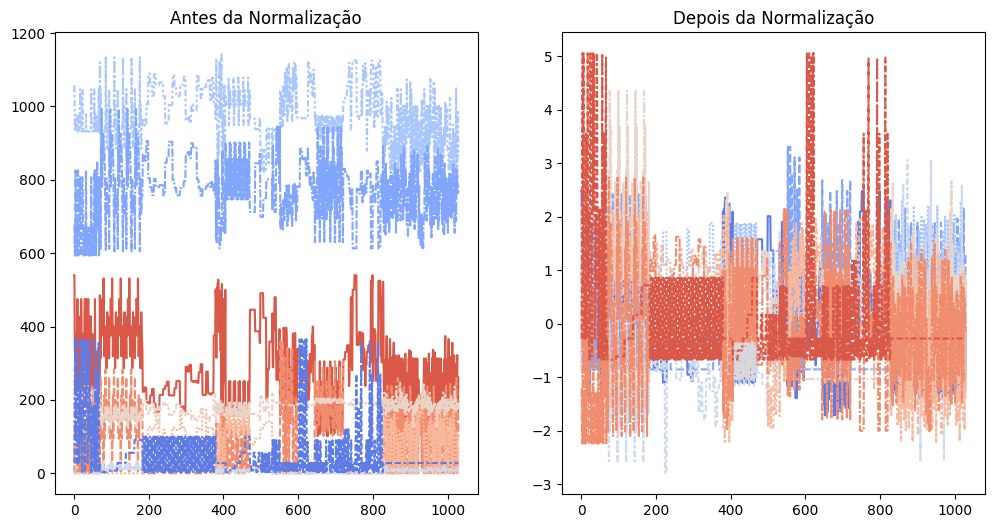

In [ ]:
# Normalizando os dados
_, X_regr_norm = normalize_data(X_regr)
X_regr = X_regr.values

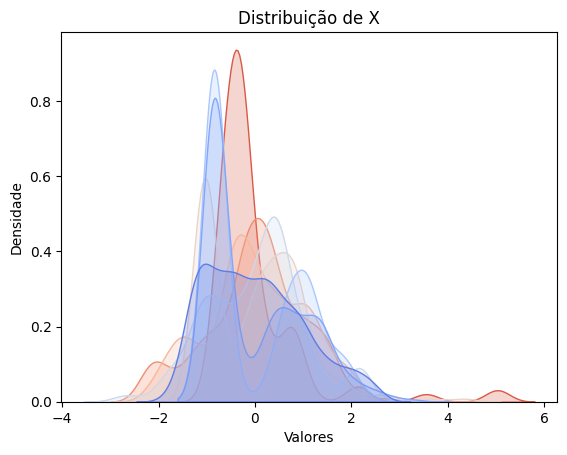

In [ ]:
plot_gaussian_distribution(data=X_regr_norm)

## a) Divisão dos Dados e Treinamento do Modelo

> Considere um modelo de **regressão não linear** baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste
(por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo
abaixo:
> - **MLP (*Multilayer Perceptron*):** 1 camada oculta e treinamento
em *minibatch* via gradiente descendente estocástico com termo de *momentum*. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [ ]:
from sklearn.model_selection import train_test_split

# Separando os conjuntos de treinamento, validação e teste
X_regr_train, X_regr_test, y_regr_train, y_regr_test = train_test_split(X_regr_norm, y_regr, test_size=0.2, random_state=42)
X_regr_train, X_regr_val, y_regr_train, y_regr_val = train_test_split(X_regr_train, y_regr_train, test_size=0.25, random_state=42)

(X_regr_train.shape, y_regr_train.shape), (X_regr_val.shape, y_regr_val.shape), (X_regr_test.shape, y_regr_test.shape)

(((618, 8), (618,)), ((206, 8), (206,)), ((206, 8), (206,)))

In [ ]:
param_grid_regr = {
    'hidden_units': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'identity', 'tanh']
}

mlp_regr_ = MLPModel(epochs=1000, momentum=0.9)

# Realizando a busca aleatória dos melhores hiperparâmetros
best_params_regr, best_epoch_regr, train_loss_regr, val_loss_regr, train_metrics_regr, val_metrics_regr = random_search(mlp_regr_,
                                                                                                                        X_train=X_regr_train, y_train=y_regr_train,
                                                                                                                        X_val=X_regr_val, y_val=y_regr_val,
                                                                                                                        param_grid=param_grid_regr, num_searches=40)

-------------------------------------------------------------------
Modelo 1

    hidden_units=64
    batch_size=64
    learning_rate=0.1
    activation=relu

Early stopping! Modelo treinado até a época 24 com paciência de 5.
-------------------------------------------------------------------
Modelo 2

    hidden_units=32
    batch_size=32
    learning_rate=0.1
    activation=identity



<ipython-input-6-434384a7f6e1>:172: RuntimeWarning: overflow encountered in square
  return np.mean((y_pred - y) ** 2) # MSE para regressão
<ipython-input-5-ea465fcaf95f>:2: RuntimeWarning: overflow encountered in square
  mse = np.mean((y_real - y_pred) ** 2)


Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 3

    hidden_units=32
    batch_size=64
    learning_rate=0.001
    activation=identity

Early stopping! Modelo treinado até a época 10 com paciência de 5.
-------------------------------------------------------------------
Modelo 4

    hidden_units=128
    batch_size=64
    learning_rate=0.001
    activation=identity

Early stopping! Modelo treinado até a época 13 com paciência de 5.
-------------------------------------------------------------------
Modelo 5

    hidden_units=64
    batch_size=32
    learning_rate=0.1
    activation=tanh

Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 6

    hidden_units=32
    batch_size=64
    learning_rate=0.1
    activation=tanh

Early stopping! Modelo treinado até a época 11 com paciência de 5.
------------------

<ipython-input-6-434384a7f6e1>:201: RuntimeWarning: overflow encountered in multiply
  dZ2 = 2 * (self.A2 - y.reshape(-1, 1)) / num_examples # Derivada para regressão
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 35

    hidden_units=128
    batch_size=64
    learning_rate=0.01
    activation=relu

Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 36

    hidden_units=128
    batch_size=64
    learning_rate=0.1
    activation=identity

Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 37

    hidden_units=64
    batch_size=32
    learning_rate=0.01
    activation=tanh

Early stopping! Modelo treinado até a época 6 com paciência de 5.
-------------------------------------------------------------------
Modelo 38

    hidden_units=128
    batch_size=64
    learning_rate=0.01
    activation=tanh

Early stopping! Modelo treinado até a época 6 com paciência de 5.
--------------------

In [ ]:
best_epoch_regr

16

## b) Curvas da Função de Custo e Avaliação

> Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também para os conjuntos de treino, validação e teste as métricas abaixo:
> - **RMSE (root mean squared error):** $\sqrt{\frac{1}{N}\sum_{i}^{}(y_{i}-\hat{y_{i}})^{2}}$;
> - **MAE (mean absolute error):** $\frac{1}{N}\sum_{i}^{}\left|y_{i}-\hat{y_{i}}\right|$;
> - **MRE (mean relative error):** $\frac{1}{N}\sum_{i}^{}\left|\frac{y_{i}-\hat{y_{i}}}{y_{i}}\right|$.

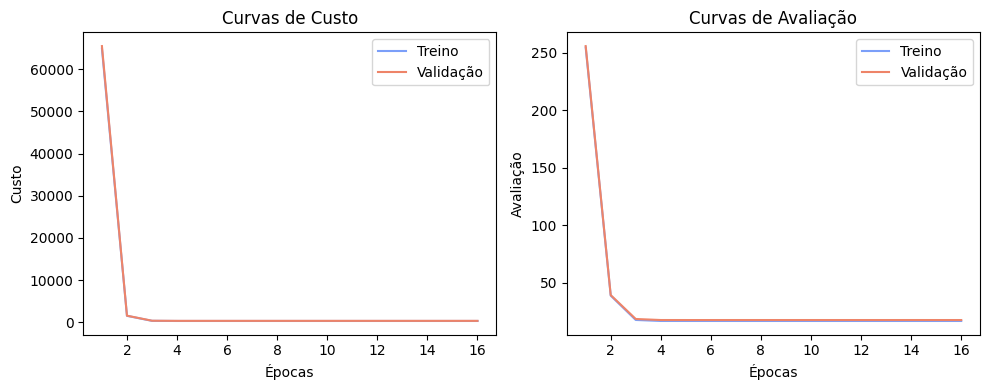

In [ ]:
# Obtendo o histórico dos conjuntos de treinamento e validação
plot_loss_and_metrics(train_loss_regr,
                      val_loss_regr,
                      [v[0] for v in train_metrics_regr],
                      [v[0] for v in val_metrics_regr])

In [ ]:
from itertools import zip_longest

pd.DataFrame(zip_longest(y_regr_train, y_regr_val, y_regr_test, fillvalue=0), columns=['train', 'val', 'test']).describe()

,train,val,test
count,618.000000,618.000000,618.000000
mean,35.914110,11.896375,11.886117
std,16.660632,19.629383,19.210648
min,2.330000,0.000000,0.000000
25%,23.802500,0.000000,0.000000
50%,33.945000,0.000000,0.000000
75%,45.930000,21.955000,23.802500
max,82.600000,81.750000,75.500000


In [ ]:
# Criando uma instância do MLPModel com os melhores hiperparâmetros para regressão
mlp_regr = MLPModel(epochs=best_epoch_regr, momentum=0.9)

# Definindo os parâmetros da instância do MLPModel com os melhores hiperparâmetros encontrados para regressão
mlp_regr.set_params(**best_params_regr)

# Ajustando o modelo aos dados de treinamento e validação combinados
mlp_regr.fit(
    np.concatenate((X_regr_train, X_regr_val), axis=0),  # Concatena os conjuntos de treinamento e validação
    np.concatenate((y_regr_train, y_regr_val), axis=0),
    random_seed=42,
    verbose=True  # Imprime informações sobre o processo de treinamento
)

Epoch 1/16
12/12  [============] - loss: 326.1837 - rmse: 18.0606 - mae: 14.6886 - mre: 72.40%
Epoch 2/16
12/12  [============] - loss: 284.2818 - rmse: 16.8607 - mae: 13.5447 - mre: 59.34%
Epoch 3/16
12/12  [============] - loss: 284.2878 - rmse: 16.8608 - mae: 13.5918 - mre: 60.96%
Epoch 4/16
12/12  [============] - loss: 287.5872 - rmse: 16.9584 - mae: 13.6737 - mre: 61.68%
Epoch 5/16
12/12  [============] - loss: 290.1074 - rmse: 17.0325 - mae: 13.8110 - mre: 64.46%
Epoch 6/16
12/12  [============] - loss: 915.5047 - rmse: 30.2573 - mae: 18.9261 - mre: 67.41%
Epoch 7/16
12/12  [============] - loss: 284.3529 - rmse: 16.8628 - mae: 13.5594 - mre: 59.76%
Epoch 8/16
12/12  [============] - loss: 295.1177 - rmse: 17.1790 - mae: 13.6873 - mre: 59.34%
Epoch 9/16
12/12  [============] - loss: 284.3073 - rmse: 16.8614 - mae: 13.5668 - mre: 60.04%
Epoch 10/16
12/12  [============] - loss: 284.3709 - rmse: 16.8633 - mae: 13.5978 - mre: 61.13%
Epoch 11/16
12/12  [============] - loss: 284.111

In [ ]:
# Avaliando o modelo nos conjuntos de treinamento, validação e teste
y_regr_train_pred = mlp_regr.predict(X_regr_train)
y_regr_val_pred = mlp_regr.predict(X_regr_val)
y_regr_test_pred = mlp_regr.predict(X_regr_test)

# Calculando as métricas RMSE, MAE e MRE
rmse_train = get_rmse(y_regr_train, y_regr_train_pred)
rmse_val = get_rmse(y_regr_val, y_regr_val_pred)
rmse_test = get_rmse(y_regr_test, y_regr_test_pred)

mae_train = get_mae(y_regr_train, y_regr_train_pred)
mae_val = get_mae(y_regr_val, y_regr_val_pred)
mae_test = get_mae(y_regr_test, y_regr_test_pred)

mre_train = get_mre(y_regr_train, y_regr_train_pred)
mre_val = get_mre(y_regr_val, y_regr_val_pred)
mre_test = get_mre(y_regr_test, y_regr_test_pred)

print("train_rmse: {:.2f} - val_rmse: {:.2f} - test_rmse: {:.2f}%".format(rmse_train, rmse_val, rmse_test))
print("train_mae: {:.2f} - val_mae: {:.2f} - test_mae: {:.2f}%".format(mae_train, mae_val, mae_test))
print("train_mre: {:.2f} - val_mre: {:.2f} - test_mre: {:.2f}%".format(mre_train, mre_val, mre_test))

train_rmse: 16.65 - val_rmse: 17.46 - test_rmse: 16.06%
train_mae: 13.38 - val_mae: 14.15 - test_mae: 13.06%
train_mre: 59.89 - val_mre: 61.86 - test_mre: 60.21%


# Questão 2

Considere o conjunto de dados disponível em `vowel.csv`, organizado em 11 colunas, sendo as 10 primeiras colunas os atributos e a última coluna a saída.

Os 10 atributos referem-se à caracterização de amostras da fala de britânicos. A saída é o fonema de vogal correspondente, dentre as 11 possibilidades.

In [ ]:
df_clf = pd.read_csv('vowel.csv', header=None)

df_clf.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,8.0
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,2.0
2,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,1.0
3,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,0.0
4,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,5.0


In [ ]:
df_clf.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,-3.203740,1.881764,-0.507770,0.515483,-0.305658,0.630244,-0.004365,0.336553,-0.302976,-0.071339,5.000000
std,0.868987,1.175272,0.711948,0.759261,0.664602,0.603871,0.461927,0.573302,0.570162,0.603985,3.163876
min,-5.211000,-1.274000,-2.487000,-1.409000,-2.127000,-0.836000,-1.537000,-1.293000,-1.613000,-1.680000,0.000000
25%,-3.887750,1.051500,-0.975750,-0.065500,-0.769000,0.196000,-0.307000,-0.095750,-0.704000,-0.548000,2.000000
50%,-3.145500,1.876500,-0.572500,0.433500,-0.299000,0.552000,0.022000,0.328000,-0.302500,-0.156500,5.000000
75%,-2.602500,2.738000,-0.068750,1.096000,0.169500,1.028500,0.296500,0.770000,0.093750,0.371000,8.000000
max,-0.941000,5.074000,1.431000,2.377000,1.831000,2.327000,1.403000,2.039000,1.309000,1.396000,10.000000


In [ ]:
df_clf.iloc[:, -1:].value_counts()

10  
0.0     90
1.0     90
2.0     90
3.0     90
4.0     90
5.0     90
6.0     90
7.0     90
8.0     90
9.0     90
10.0    90
dtype: int64

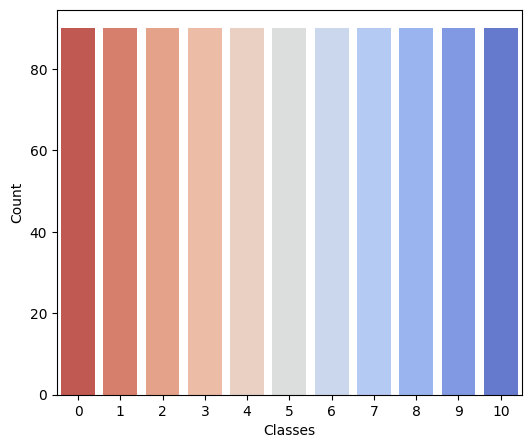

In [ ]:
class_data = [i*j for i, j in df_clf.iloc[:, -1:].value_counts().items()]

plot_class_counts(class_data, width=6, height=5, palette='coolwarm_r')

In [ ]:
X_clf = df_clf.iloc[:, :-1]
y_clf = df_clf.iloc[:, -1:].values.ravel()

X_clf.shape, y_clf.shape

((990, 10), (990,))

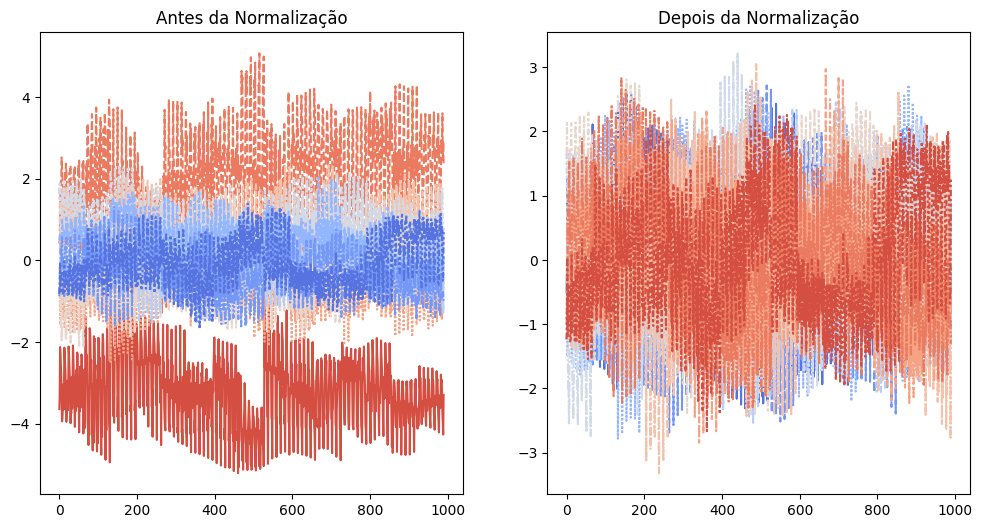

In [ ]:
_, X_clf_norm = normalize_data(X_clf)
X_clf = X_clf.values

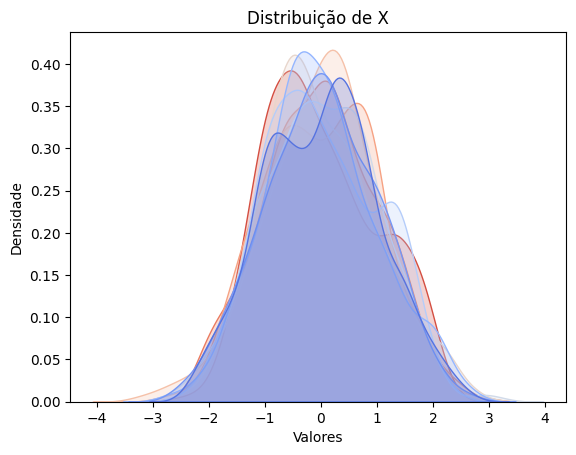

In [ ]:
plot_gaussian_distribution(data=X_clf_norm)

## a) Divisão dos Dados e Treinamento do Modelo

> Considere um modelo de **classificação não linear** baseado em redes neurais artificiais. Separe os dados aleatoriamente em treino, validação e teste
(por exemplo, 60%, 20% e 20%). Nesse cenário, treine e avalie o modelo
abaixo:
> - **MLP (*Multilayer Perceptron*):** 1 camada oculta e treinamento
em *minibatch* via gradiente descendente estocástico com termo de *momentum*. Utilize o conjunto de validação para ajustar os hiperparâmetros.

In [ ]:
from sklearn.model_selection import train_test_split

# Separando os conjuntos de treinamento, validação e teste
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(X_clf_norm, y_clf, test_size=0.2, random_state=42)
X_clf_train, X_clf_val, y_clf_train, y_clf_val = train_test_split(X_clf_train, y_clf_train, test_size=0.25, random_state=42)

(X_clf_train.shape, y_clf_train.shape), (X_clf_test.shape, y_clf_test.shape), (X_clf_val.shape, y_clf_val.shape)

(((594, 10), (594,)), ((198, 10), (198,)), ((198, 10), (198,)))

In [ ]:
param_grid_clf = {
    'hidden_units': [32, 64, 128],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'leaky_relu', 'tanh']
}

mlp_clf_ = MLPModel(epochs=1000, momentum=0.9)

# Realizando a busca aleatória dos melhores hiperparâmetros
best_params_clf, best_epoch_clf, train_loss_clf, val_loss_clf, train_metrics_clf, val_metrics_clf = random_search(model=mlp_clf_,
                                                                                                                  X_train=X_clf_train, y_train=y_clf_train.astype(int),
                                                                                                                  X_val=X_clf_val, y_val=y_clf_val.astype(int),
                                                                                                                  param_grid=param_grid_clf, num_searches=40)

-------------------------------------------------------------------
Modelo 1

    hidden_units=64
    batch_size=32
    learning_rate=0.1
    activation=relu

Early stopping! Modelo treinado até a época 145 com paciência de 5.
-------------------------------------------------------------------
Modelo 2

    hidden_units=64
    batch_size=16
    learning_rate=0.01
    activation=leaky_relu

Early stopping! Modelo treinado até a época 862 com paciência de 5.
-------------------------------------------------------------------
Modelo 3

    hidden_units=128
    batch_size=32
    learning_rate=0.001
    activation=tanh

-------------------------------------------------------------------
Modelo 4

    hidden_units=128
    batch_size=16
    learning_rate=0.001
    activation=leaky_relu

-------------------------------------------------------------------
Modelo 5

    hidden_units=32
    batch_size=64
    learning_rate=0.01
    activation=leaky_relu

-------------------------------------------

In [ ]:
best_epoch_clf

103

## b) Curvas da Função de Custo e Avaliação

> Apresente as curvas da função custo nos conjuntos de treinamento e validação ao longo das épocas. Reporte também a **acurácia** obtida para os **conjuntos de treino, validação e teste**.

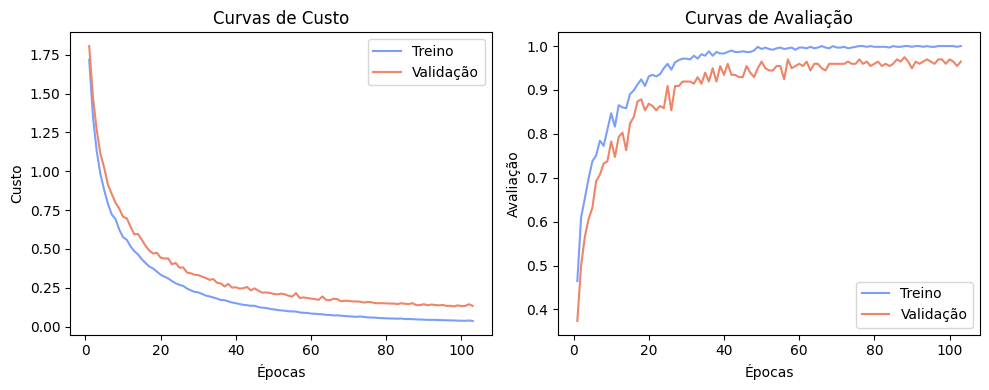

In [ ]:
# Obtendo o histórico dos conjuntos de treinamento e validação
plot_loss_and_metrics(train_loss_clf,
                      val_loss_clf,
                      train_metrics_clf,
                      val_metrics_clf)

In [ ]:
# Criando uma instância do MLPModel com os melhores hiperparâmetros para classificação
mlp_clf = MLPModel(epochs=best_epoch_clf, momentum=0.9)

# Definindo os parâmetros da instância do MLPModel com os melhores hiperparâmetros encontrados para classificação
mlp_clf.set_params(**best_params_clf)

# Ajustando o modelo aos dados de treinamento e validação combinados
mlp_clf.fit(
    np.concatenate((X_clf_train, X_clf_val), axis=0),  # Concatena os conjuntos de treinamento e validação
    np.concatenate((y_clf_train, y_clf_val), axis=0),
    random_seed=42,
    verbose=True  # Imprime informações sobre o processo de treinamento
)

Epoch 1/103
49/49  [=================================================] - loss: 1.6134 - accuracy: 0.4874
Epoch 2/103
49/49  [=================================================] - loss: 1.2313 - accuracy: 0.6465
Epoch 3/103
49/49  [=================================================] - loss: 1.0029 - accuracy: 0.6970
Epoch 4/103
49/49  [=================================================] - loss: 0.8617 - accuracy: 0.7588
Epoch 5/103
49/49  [=================================================] - loss: 0.7610 - accuracy: 0.7513
Epoch 6/103
49/49  [=================================================] - loss: 0.6911 - accuracy: 0.7980
Epoch 7/103
49/49  [=================================================] - loss: 0.6168 - accuracy: 0.8182
Epoch 8/103
49/49  [=================================================] - loss: 0.5658 - accuracy: 0.8283
Epoch 9/103
49/49  [=================================================] - loss: 0.5230 - accuracy: 0.8510
Epoch 10/103
49/49  [==================================

In [ ]:
y_clf_train_pred = mlp_clf.predict(X_clf_train)
y_clf_val_pred = mlp_clf.predict(X_clf_val)
y_clf_test_pred = mlp_clf.predict(X_clf_test)

acc_train = get_accuracy(y_clf_train, y_clf_train_pred)
acc_val = get_accuracy(y_clf_val, y_clf_val_pred)
acc_test = get_accuracy(y_clf_test, y_clf_test_pred)

# Imprimindo as acurácias
print("train_accuracy: {:.2f} - val_accuracy: {:.2f} - test_accuracy: {:.2f}".format(acc_train, acc_val, acc_test))

train_accuracy: 1.00 - val_accuracy: 1.00 - test_accuracy: 0.97
